# INS



In [1]:
%matplotlib inline

In [2]:
from __future__ import print_function, division
import numpy as np # matrix manipulations
from matplotlib import pyplot as plt           # this lets you draw inline pictures in the notebooks
import pylab                                   # this allows you to control figure size 
pylab.rcParams['figure.figsize'] = (10.0, 10.0) # this controls figure size in the notebook

In [3]:
from math import sin, cos, atan2, pi, sqrt, asin
from math import radians as deg2rad
from math import degrees as rad2deg

In [152]:
import datetime
import time

def load_timestamps(path):
    """Load timestamps from file."""
#     timestamp_file = os.path.join(self.sequence_path, 'times.txt')

    # Read and parse the timestamps
    start = None
    timestamps = []
    with open(path, 'r') as f:
        for line in f.readlines():
#             t = dt.timedelta(seconds=float(line))
            tmp = line[:-11]  # too many decimal place to handle
#             print(line)
            t = time.mktime(datetime.datetime.strptime(tmp, "%Y-%m-%d %I:%M:%S").timetuple())
            t = t + float(line[-11:])
            if start is None:
                start = t
            timestamps.append(t - start)
    return timestamps

In [153]:
stamps = load_timestamps('./2011_09_28_drive_0001_sync/oxts/timestamps.txt')

In [11]:
from pykitti_utils import load_oxts_packets_and_poses
from glob import glob

def get_oxts(path):
    ts_file = path + 'timestamps.txt'
    files = glob(path)
    ag = load_oxts_packets_and_poses(files)

In [12]:
from squaternion import Quaternion, euler2quat, quat2euler, quatNorm

In [183]:
#your python code here
def normalize(x, y, z):
    """Return a unit vector"""
    norm = sqrt(x * x + y * y + z * z)

    # already a unit vector
    if norm == 1.0:
        return (x, y, z)

    if norm > 0.0:
        inorm = 1/norm
        x *= inorm
        y *= inorm
        z *= inorm
    else:
        raise Exception('division by zero: {} {} {}'.format(x, y, z))
    return (x, y, z,)

def skew4(wx, wy, wz):  # titterton 11.35
    return np.array([
        (0, -wx, -wy, -wz),
        (wx, 0, wz, -wy),
        (wy, -wz, 0, wx),
        (wz, wy, -wx, 0)
    ])

def skew3(wx, wy, wz):
    return np.array([
        (0, -wz, wy),
        (wz, 0, -wx),
        (-wy, wx, 0)
    ])

In [14]:
def gps2ecef(lat, lon, H):
    # phi = lat
    # lambda = lon
    # H = height above mean sea-level (altitude)
    e = 1.0
    re = 6378137.0  # radius of Earth in meters
    
    # convert degrees to angles
    lat *= pi/180
    lon *= pi/180
    
    rm = re * (1.0 - e**2) / pow(1.0 - e**2 * sin(lat)**2, 3.0 / 2.0)
    rn = re / sqrt(1.0 - e**2 * sin(lat)**2)
    x = (rn + H) * cos(lat) * cos(lon)
    y = (rn + H) * cos(lat) * sin(lon)
    z = (rm + H) * sin(lat)
    return x, y, z

In [167]:
from pyrk import RK4

class Sim(object):
    def __init__(self, eom, a, g, tm):
        self.eom = eom
        
        # grab the inertial sensors
#         self.accels = [x.linear_accel for x in imu]
#         self.gyros = [x.angular_vel for x in imu]
#         self.mags = [x.magnetic_field for x in imu]
        self.accels = a
        self.gyros = g
        self.dts = tm
        
        # make a relative delta time from the first time step
#         dts = [x.timestamp for x in imu]
#         start = dts[0]
#         self.dts = [x - start for x in dts]
#         self.dts = np.arange(0, (len(a)-1)*0.1, 0.1)  # 10Hz
    
#         print(len(a))
#         print(len(g))
#         print(len(self.dts))
    
    def run_nav(self):
        """
        These are the navigation only equations, no EKF corrections
        """
        rk = RK4(self.eom)
        
        # initial states
        vel = (0,0,0)
        pos = (0,0,0)
        orient = (1,0,0,0)
        X = np.array(vel + pos + orient)
        
        save = []
        
        last = self.dts[0]-0.1
        for i, tm in enumerate(self.dts):
            u = self.accels[i] + self.gyros[i]
            X = rk.step(X,u,tm,tm-last)
            last = tm
            save.append(X)
            
        print(">> Simulation end: {:.2f} seconds".format(tm))
            
        return save, self.dts

In [22]:
oxts = get_oxts('./2011_09_28_drive_0001_sync/oxts/data/*.txt')
accels = [(x.packet.ax/9.81,x.packet.ay/9.81,x.packet.az/9.81,) for x in oxts]
gyros = [(x.packet.wx,x.packet.wy,x.packet.wz,) for x in oxts]

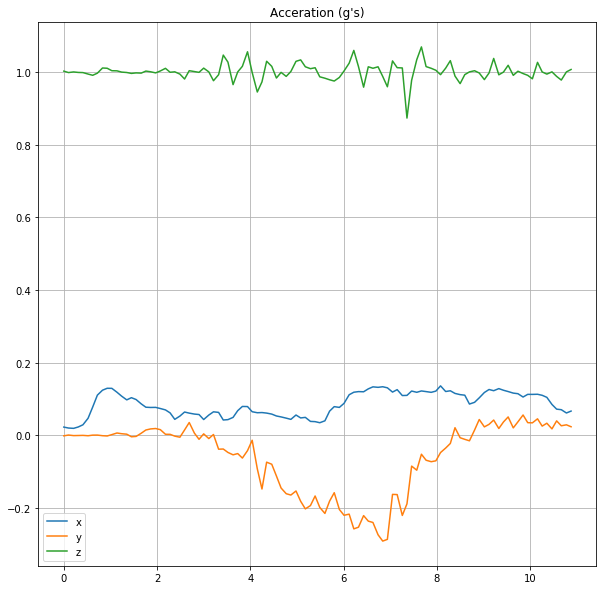

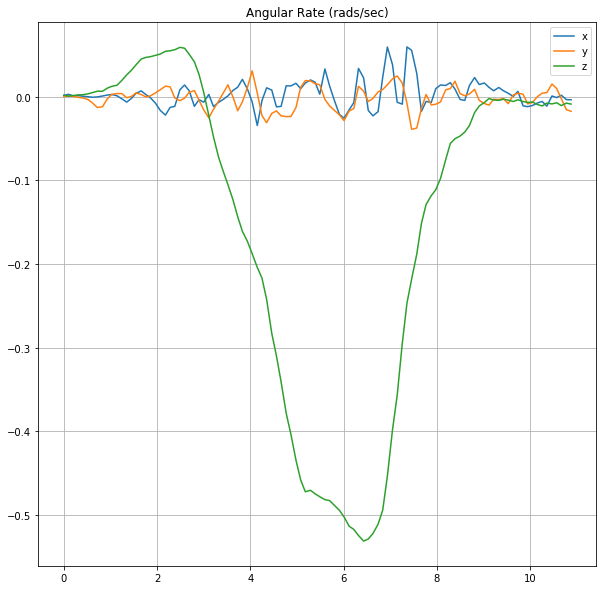

In [168]:
for s, title in zip([accels, gyros], ['Acceration (g\'s)', 'Angular Rate (rads/sec)']):
    plt.figure()
    plt.plot(stamps, [x[0] for x in s], label='x')
    plt.plot(stamps, [x[1] for x in s], label='y')
    plt.plot(stamps, [x[2] for x in s], label='z')
    plt.grid(True)
    plt.title(title)
    plt.legend()

In [77]:
from squaternion import quatNorm

In [179]:
# System equations of motion (eom)
# these follow the Titterton ECEF derivation
def eom(t, X, u):
    """
    State vector
    X = tuple[vx vy vz px py pz qw qx qy qz]
    v - velocity
    p - position
    q - quaternion (orientation)

    These are sensor readings from IMU
    u = [fx fy fz wx wy wz]
    f - force (acceleration)
    w - angular velocity (from gyros)
    """
    # imu ---------------------
    f = 9.81*np.array(u[0:3]) 
    wx, wy, wz = u[3:]
    W = skew4(wx, wy, wz)
    
    # state -------------------
    v = np.array(X[0:3])
    p = np.array(X[3:6])
    q = np.array(X[6:])
    
    # nav const --------------
    wie = np.array([0, 0, 7.292115E-15])
    Ceb = np.eye(3) # ???
    g = np.array([0,0,-9.81])
    
    # update local gravity model
    gl = g - np.cross(wie, np.cross(wie, p))
    
    # velocity update
    vd = Ceb.dot(f)-2.0*np.cross(wie, np.cross(wie, v)) + gl
    
    # position update
    pd = v
    
    # orientation update
    qd = 0.5 * W.dot(q)

    # print('vd', vd)
    # print('pd', pd)
    # print('qd', qd)

    XX = np.hstack((vd, pd, qd))
    return XX

In [180]:
s = Sim(eom, accels, gyros, stamps)
X, timestamps = s.run_nav()

>> Simulation end: 10.88 seconds


In [181]:
vel = [x[:3] for x in X]
pos = [x[3:6] for x in X]
orient = [x[6:] for x in X]

print(len(stamps))
print(len(pos))

106
106


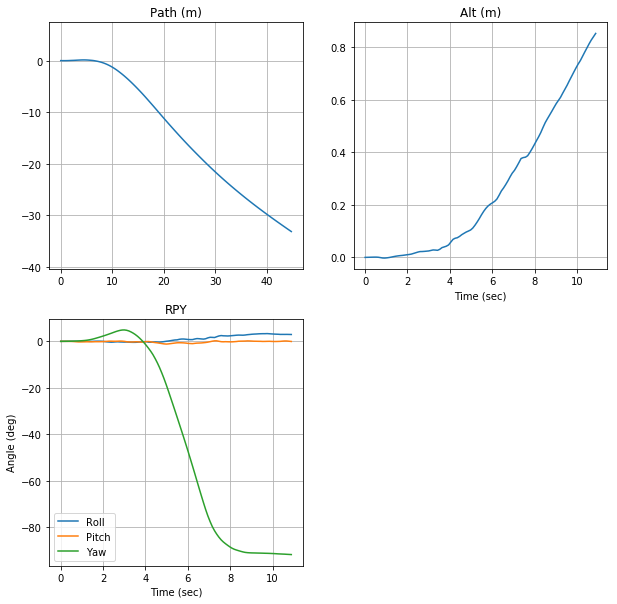

In [182]:
x = [x[0] for x in pos]
y = [x[1] for x in pos]
z = [x[2] for x in pos]

plt.subplot(2,2,1)
plt.plot(x,y)
plt.grid(True)
plt.axis('equal')
plt.title('Path (m)')

plt.subplot(2,2,2)
plt.plot(timestamps, z)
plt.xlabel('Time (sec)')
plt.grid(True)
plt.title('Alt (m)')

rpy = [quat2euler(*x, degrees=True) for x in orient]
r = [x[0] for x in rpy]
p = [x[1] for x in rpy]
y = [x[2] for x in rpy]

plt.subplot(2,2,3)
plt.plot(timestamps, r, label='Roll')
plt.plot(timestamps, p, label='Pitch')
plt.plot(timestamps, y, label='Yaw')
plt.grid(True)
plt.xlabel('Time (sec)')
plt.ylabel('Angle (deg)')
plt.legend()
plt.title('RPY');

In [177]:
# class GroundTruth(object):
#     def __init__(self, path):
#         self.path = path
    
#     def _load_timestamps(self):
#         """Load timestamps from file."""
#         timestamp_file = os.path.join(self.sequence_path, 'times.txt')

#         # Read and parse the timestamps
#         self.timestamps = []
#         with open(timestamp_file, 'r') as f:
#             for line in f.readlines():
#                 t = dt.timedelta(seconds=float(line))
#                 self.timestamps.append(t)

#         # Subselect the chosen range of frames, if any
#         if self.frames is not None:
#             self.timestamps = [self.timestamps[i] for i in self.frames]

#     def _load_poses(self):
#         """Load ground truth poses (T_w_cam0) from file."""
# #         pose_file = os.path.join(self.pose_path, self.sequence + '.txt')

#         # Read and parse the poses
#         poses = []
#         try:
#             with open(pose_file, 'r') as f:
#                 lines = f.readlines()
#                 if self.frames is not None:
#                     lines = [lines[i] for i in self.frames]

#                 for line in lines:
#                     T_w_cam0 = np.fromstring(line, dtype=float, sep=' ')
#                     T_w_cam0 = T_w_cam0.reshape(3, 4)
#                     T_w_cam0 = np.vstack((T_w_cam0, [0, 0, 0, 1]))
#                     poses.append(T_w_cam0)

In [ ]:
def eom2(t, X, u):
    """
    State vector
    X = tuple[vx vy vz px py pz qw qx qy qz]
    v - velocity
    p - position
    q - quaternion (orientation)

    These are sensor readings from IMU
    u = [fx fy fz wx wy wz]
    f - force (acceleration)
    w - angular velocity (from gyros)
    """
    # imu ---------------------
    f = 9.81*np.array(u[0:3]) 
    wx, wy, wz = u[3:]
    W = skew4(wx, wy, wz)
    
    # state -------------------
    v = np.array(X[0:3])
    p = np.array(X[3:6])
    q = np.array(X[6:])
    
    # nav const --------------
    wie = np.array([0, 0, 7.292115E-15])
    Ceb = Cne.dot(Cnb)
    g = np.array([0,0,-9.81])
    
    # update local gravity model
    gl = g - np.cross(wie, np.cross(wie, p))
    
    # velocity update
    vd = Ceb.dot(f)-2.0*np.cross(wie, np.cross(wie, v)) + gl
    
    # position update
    pd = v
    
    # orientation update
    qd = 0.5 * W.dot(q)

    # print('vd', vd)
    # print('pd', pd)
    # print('qd', qd)

    XX = np.hstack((vd, pd, qd))
    return XX